# Class Session 10 - Date Hubs and Party Hubs

## Comparing the histograms of local clustering coefficients of date hubs and party hubs

In this class, we will analyze the protein-protein interaction network for two classes of yeast proteins, "date hubs" and "party hubs" as defined by Han et al. in their 2004 study of protein-interaction networks and gene expression (Han et al., Nature, v430, p88, 2004). The authors of that study claimed that there is no difference in the local clustering density, between "date hubs" and "party hubs".  We will put this to the test. We for each of the "date hub" and "party hub" proteins, we will compute its local clustering coefficient (*C<sub>i</sub>*) in the protein-protein interaction network.  We will then histogram the *C<sub>i</sub>*) values for the two sets of hubs, so that we can compare the distributions of local clustering coefficients for "date hubs" and "party hubs". We will use a statistical test (Kolmogorov-Smirnov) to compare the two distributions of *C<sub>i</sub>* values.

To get started, we load the python packages that we will require:

In [1]:
import igraph
import numpy
import pandas
import matplotlib.pyplot

The `scipy` package doesn't import the `stats` module automatically. so we have to force its import using `from`

In [2]:
from scipy import stats

Next, we'll load the file of hub types `shared/han_hub_data.txt` (which is a two-column TSV file in which the first column is the protein name and the second column contains the string `date` or `party` for each row; the first row of the file contains the column headers), using our old friend `pandas.read_csv`. This file has a header so pass `header=0` to `read_csv`.

In [3]:
hub_data = pandas.read_csv("shared/han_hub_data.txt", sep="\t", header=0)

Let's take a peek at the structure of the `hub_data` data frame, using `head` and `shape`.  Here's what it should look like:

In [4]:
hub_data.head()

,Protein,HubType
0,ACT1,date
1,ADA2,date
2,AKR1,party
3,APC1,party
4,APC11,date


In [5]:
hub_data.shape

(199, 2)

Next, let's load the file of yeat protein-protein interaction network edges `shared/han_network_edges.txt` (which is a two-column file, with first column is the first protein in the interacting pair, and the second column is the second protein in the interacting pair).This file has a header so pass `header=0` to `read_csv`.

In [6]:
edge_data = pandas.read_csv("shared/han_network_edges.txt", sep="\t", header=0)

Let's take a peek at the data frame `edge_df`, using `head` and `shape`:

make an undirected igraph `Graph` from the edgelist data; show summary data on the graph as a sanity-check

In [7]:
edge_data.head()

,PROTEINA,PROTEINB
0,AAR2,PRP8
1,ABP1,SRV2
2,ABP1,ACT1
3,ABP1,RVS167
4,ACT1,IQG1


In [8]:
edge_data.shape

(2523, 2)

It will be convenient to let `igraph` compute the local clustering coefficients.  So, we'll want to make an undirected igraph `igraph.Graph` object from the edgelist data, using our old friend `igraph.Graph.TupleList`:

In [9]:
ppi_graph = igraph.Graph.TupleList(edge_data.values.tolist(), directed=False)

As always, we'll use `igraph.Graph.summary` to sanity check the `Graph` object:

In [10]:
ppi_graph.summary()

'IGRAPH UN-- 1344 2523 -- \n+ attr: name (v)'

Generate a list of the names of the proteins in the order of the proteins' corresponding vertices in the igraph `Graph` object

In [11]:
graph_vertices = ppi_graph.vs()["name"]

In [12]:
graph_vertices[0:9]

['AAR2', 'PRP8', 'ABP1', 'SRV2', 'ACT1', 'RVS167', 'IQG1', 'AIP1', 'COF1']

Make a dataframe containing the protein names (as column "Protein") using `pandas.DataFrame` and `pandas.Series`. Set the column name to `Protein` using the `columns` attribute on the data frame. Define a new column `order` that will contain the list of IDs in `graph_vertices_df.index`.

In [13]:
graph_vertices_df = pandas.DataFrame(pandas.Series(graph_vertices))
graph_vertices_df.columns = ["Protein"]
graph_vertices_df["order"]=graph_vertices_df.index

Let's take a peek at this data frame:

In [14]:
graph_vertices_df.head()

,Protein,order
0,AAR2,0
1,PRP8,1
2,ABP1,2
3,SRV2,3
4,ACT1,4


Let's use the `pandas.DataFrame.merge` method on the `graph_vertices_df` object to pull in the hub type (date or party) for vertices that are hubs, by passing `hub_data` to `merge`.  Don't forget to specify `how='outer'` and `on="Protein"`:

In [15]:
graph_vertices_df_merged = graph_vertices_df.merge(hub_data, how='outer', on="Protein")
graph_vertices_df_merged = graph_vertices_df_merged.sort_values("order")

Having merged the hub type information into `graph_vertices_df`, let's take a peek at it using `head` and `shape`:

In [16]:
graph_vertices_df_merged.head()

,Protein,order,HubType
0,AAR2,0,NaN
1,PRP8,1,party
2,ABP1,2,NaN
3,SRV2,3,NaN
4,ACT1,4,date


NOTE: a `NaN` in the `HubType` column means that the protein is not a hub.

In [17]:
graph_vertices_df.shape

(1344, 2)

Let's pull out the `HubType` column as a numpy array, using column indexing (`["HubType"]`) and then `values.tolist()`:

In [18]:
vertex_types_np = numpy.array(graph_vertices_df_merged["HubType"].values.tolist())

Let's take a peek at this `numpy.array` that we have just created:

In [19]:
vertex_types_np

array(['nan', 'party', 'nan', ..., 'nan', 'nan', 'nan'], dtype='<U32')

Use `numpy.where` in order to find the index numbers of the proteins that are "date hubs" and that are "party hubs":

In [20]:
date_hub_inds = numpy.where(vertex_types_np == "date")
party_hub_inds = numpy.where(vertex_types_np == "party")

Use the `igraph.Graph.transitivity_local_undirected` function in igraph to compute the local clustering coefficients for every vertex in the graph. Make a `numpy.array` from the resulting list of Ci values:

In [21]:
ci_values = ppi_graph.transitivity_local_undirected()
ci_values_np = numpy.array(ci_values)

Let's take a peek at the `ci_values_np` array that you have just created.  What are the `nan` values, and what do they signify?  Is this normal?

In [22]:
ci_values_np

array([       nan, 0.10714286, 0.66666667, ..., 0.        ,        nan,
              nan])

Make a `numpy.array` of the Ci values of the date hubs (`ci_values_date_hubs`) and the Ci values of the party hubs (`ci_values_party_hubs`)

In [23]:
ci_values_date_hubs = ci_values_np[date_hub_inds]
ci_values_party_hubs = ci_values_np[party_hub_inds]

Plot the histograms of the local clustering coefficients of the "date hubs" and the "party hubs". Use `matplotlib.pyplot.hist`. Use alpha blending so that the two overlapping histograms can be plotted together.

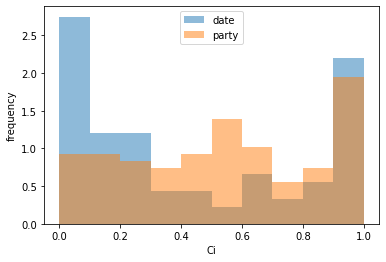

In [24]:
matplotlib.pyplot.hist(ci_values_date_hubs, density=1, alpha=0.5, label="date")
matplotlib.pyplot.hist(ci_values_party_hubs, density=1, alpha=0.5, label="party")
matplotlib.pyplot.legend(loc="upper center")
matplotlib.pyplot.xlabel("Ci")
matplotlib.pyplot.ylabel("frequency")
matplotlib.pyplot.show()

Do these histograms look the same to you? Let's test it with a Kolmogorov-Smirnov test, using the function `scipy.stats.ks_2samp`.

In [25]:
stats.ks_2samp(ci_values_date_hubs, ci_values_party_hubs)

Ks_2sampResult(statistic=0.25895400895400894, pvalue=0.0020227281019755683)